In [1]:
import torch
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
# import tqdm
# from typing import List, Tuple
from torchvision import transforms
import torch.nn.functional as F

In [2]:
import numpy as np
from typing import Tuple, Union


def convert_xyxy_to_cxcywh(
    x1: Union[int, float],
    y1: Union[int, float],
    x2: Union[int, float],
    y2: Union[int, float]
) -> Tuple[float, float, float, float]:
    cx = (x1 + x2) / 2.0
    cy = (y1 + y2) / 2.0
    w = abs(x2 - x1)
    h = abs(y2 - y1)
    return cx, cy, w, h


def convert_cxcywh_to_xyxy(
    cx: Union[int, float],
    cy: Union[int, float],
    w: Union[int, float],
    h: Union[int, float]
) -> Tuple[float, float, float, float]:
    x1 = cx - w / 2.0
    y1 = cy - h / 2.0
    x2 = cx + w / 2.0
    y2 = cy + h / 2.0
    return x1, y1, x2, y2


def convert_xywh_to_xyxy(
    x: Union[int, float],
    y: Union[int, float],
    w: Union[int, float],
    h: Union[int, float]
) -> Tuple[float, float, float, float]:
    x1 = x
    y1 = y
    x2 = x + w
    y2 = y + h
    return x1, y1, x2, y2


def convert_poly_to_yolobbox(
    polygon: np.ndarray
) -> Tuple[float, float, float, float]:
    """polygon must be a Nx2 matrix
    """
    x1 = polygon[:, 0].min()
    x2 = polygon[:, 0].max()
    y1 = polygon[:, 1].min()
    y2 = polygon[:, 1].max()
    return convert_xyxy_to_cxcywh(x1, y1, x2, y2)


def convert_yolo_to_xyxy(
    cx: Union[int, float],
    cy: Union[int, float],
    w: Union[int, float],
    h: Union[int, float],
    img_w: Union[int, float],
    img_h: Union[int, float]
) -> Tuple[float, float, float, float]:
    x1 = cx * img_w - (img_w * w) / 2.0
    x2 = cx * img_w + (img_w * w) / 2.0
    y1 = cy * img_h - (img_h * h) / 2.0
    y2 = cy * img_h + (img_h * h) / 2.0
    return x1, y1, x2, y2


def convert_normalized_to_xyxy(
    x1: Union[int, float],
    y1: Union[int, float],
    x2: Union[int, float],
    y2: Union[int, float],
    img_w: Union[int, float],
    img_h: Union[int, float]
) -> Tuple[float, float, float, float]:
    x1 = x1 * img_w
    x2 = x2 * img_w
    y1 = y1 * img_h
    y2 = y2 * img_h
    return x1, y1, x2, y2


def calc_iou(x1_min, x1_max, y1_min, y1_max, x2_min, x2_max, y2_min, y2_max):
    i_min_x = max(x1_min, x2_min)
    i_min_y = max(y1_min, y2_min)
    i_max_x = min(x1_max, x2_max)
    i_max_y = min(y1_max, y2_max)

    inter_width = max((i_max_x - i_min_x), 0)
    inter_height = max((i_max_y - i_min_y), 0)

    width_box1 = abs(x1_max - x1_min)
    height_box1 = abs(y1_max - y1_min)

    width_box2 = abs(x2_max - x2_min)
    height_box2 = abs(y2_max - y2_min)

    area1 = width_box1 * height_box1
    area2 = width_box2 * height_box2
    intersection = (inter_width * inter_height)
    union = area1 + area2 - intersection
    iou = intersection / union

    if iou < 0.0 or iou > 1.0:
        iou = 0.0

    return iou, i_min_x, i_min_y, i_max_x, i_max_y


def np_calc_iou(
    box_xyxy_gt: Tuple[float, float, float, float],
    anchor_boxes_xyxy: np.ndarray,  # Nx4 boxes in XYXY
) -> np.ndarray:
    x2_min = anchor_boxes_xyxy[:, 0:1]
    y2_min = anchor_boxes_xyxy[:, 1:2]
    x2_max = anchor_boxes_xyxy[:, 2:3]
    y2_max = anchor_boxes_xyxy[:, 3:4]

    x1_min, y1_min, x1_max, y1_max = box_xyxy_gt
    x1_min = np.ones_like(x2_min) * x1_min
    y1_min = np.ones_like(x2_min) * y1_min
    x1_max = np.ones_like(x2_min) * x1_max
    y1_max = np.ones_like(x2_min) * y1_max

    i_min_x = np.maximum(x1_min, x2_min)
    i_min_y = np.maximum(y1_min, y2_min)
    i_max_x = np.minimum(x1_max, x2_max)
    i_max_y = np.minimum(y1_max, y2_max)

    inter_width = np.clip((i_max_x - i_min_x), 0, None)
    inter_height = np.clip((i_max_y - i_min_y), 0, None)

    width_box1 = (x1_max - x1_min)
    height_box1 = (y1_max - y1_min)

    width_box2 = (x2_max - x2_min)
    height_box2 = (y2_max - y2_min)

    area1 = np.abs(width_box1 * height_box1)
    area2 = np.abs(width_box2 * height_box2)
    intersection = (inter_width * inter_height)
    union = area1 + area2 - intersection
    iou = intersection / union

    iou[(iou < 0.0) | (iou > 1.0)] = 0.0

    return iou[:, 0]  # , i_min_x, i_min_y, i_max_x, i_max_y


In [3]:
from typing import List, Tuple

def create_default_boxes(
    image_size: Tuple[int, int],                 # target image dimension [height, width]
    grid_sizes: List[Tuple[int, int]],           # [(grid1.dim0, grid1.dim0), (grid2.dim0, grid2.dim1)]
    anchors_sizes: List[List[Tuple[float, float]]],     # [(box1.width, box1.height), (box2.width, box2.height)]
    normalize: bool = True
) -> Tuple[List[Tuple[float, float, float, float]],  # boxes_xyxy
           List[Tuple[float, float, float, float]],  # boxes_xywh
           List[Tuple[float, float, float, float]]]:  # boxes_cxcywh

    image_height, image_width = image_size[:2]

    boxes_xyxy = list()
    boxes_xywh = list()
    boxes_cxcywh = list()
    
    grid_idx = 0
    for grid_dim0, grid_dim1 in grid_sizes:
        grid_size_dim0 = image_height / float(grid_dim0)
        grid_size_dim1 = image_width / float(grid_dim1)

        for i_grid in range(grid_dim0):
            for j_grid in range(grid_dim1):
                for sx, sy in anchors_sizes[grid_idx]:
                    cy = grid_size_dim0 / 2.0 + grid_size_dim0 * i_grid
                    cx = grid_size_dim1 / 2.0 + grid_size_dim1 * j_grid
                    box_w = grid_size_dim1 * sx
                    box_h = grid_size_dim0 * sy

                    x_min = cx - box_w / 2.0
                    x_max = cx + box_w / 2.0
                    y_min = cy - box_h / 2.0
                    y_max = cy + box_h / 2.0

                    if normalize:
                        cx = cx / image_width
                        cy = cy / image_height
                        box_w = box_w / image_width
                        box_h = box_h / image_height
                        x_min = x_min / image_width
                        x_max = x_max / image_width
                        y_min = y_min / image_height
                        y_max = y_max / image_height

                    boxes_xyxy.append((x_min, y_min, x_max, y_max))
                    boxes_xywh.append((x_min, y_min, box_w, box_h))
                    boxes_cxcywh.append((cx, cy, box_w, box_h))
        
        grid_idx += 1

    return boxes_xyxy, boxes_xywh, boxes_cxcywh

In [4]:
boxes_xyxy, boxes_xywh, boxes_cxcywh = create_default_boxes(
    (300, 300), 
    [ 
        (38, 38),
        (19, 19),
        (10, 10),
        (5, 5),
        (3, 3),
        (1, 1),
    ],
    [
        [(1.0, 1.0), (2.0, 1.0), (1.0,2.0), (1.0, 1.0),],
        [(1.0, 1.0), (2.0, 1.0), (3.0, 1.0), (1.0, 2.0), (1.0,3.0), (1.0, 1.0)],
        [(1.0, 1.0), (2.0, 1.0), (3.0, 1.0), (1.0, 2.0), (1.0,3.0), (1.0, 1.0)],
        [(1.0, 1.0), (2.0, 1.0), (3.0, 1.0), (1.0, 2.0), (1.0,3.0), (1.0, 1.0)],
        [(1.0, 1.0), (2.0, 1.0), (1.0, 2.0), (1.0, 1.0),],
        [(1.0, 1.0), (2.0, 1.0), (1.0, 2.0), (1.0, 1.0),],
    ]
)

default_boxes_xyxy = np.array(boxes_xyxy)
default_boxes_xywh = np.array(boxes_xywh)

In [5]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((300, 300)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
class DatasetSSDTrain(torch.utils.data.Dataset):

    def __init__(self, folder_path_yolo_dataset, *,
                 transform=None):
        super().__init__()

        self.folder_path = folder_path_yolo_dataset
        self.transform = transform

        self.images_path = list()
        
        file_names = [file_name.replace(".jpg", "") for file_name in sorted(
            os.listdir(self.folder_path)) if file_name.endswith(".jpg")]
        for file_name in file_names:
            
            file_path = os.path.join(self.folder_path, file_name + ".jpg").replace(os.sep, "/")

            self.images_path.append(file_path)

    def __len__(self) -> int:
        # return 1
        return len(self.images_path)

    def __getitem__(self, idx: int):
        img = cv2.imread(self.images_path[idx])

        if self.transform is not None:
            img = self.transform(img) 

        return img

In [7]:
dataset = DatasetSSDTrain(r'S:\Lecture Notes\2nd Semester\Group Project\Edge Computing\Datacet\dataset1\4_Sunny\sunny-visible',
                         transform=train_transform)

In [8]:
dataset_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=False, num_workers=0
)

In [9]:
model = torch.load('model_scripted.pt')

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:707: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [10]:
device=torch.device('cuda')
model=model.to(device)

In [11]:
for input_tensor in (dataset_loader):
    
    input_tensor = input_tensor.float().to(device)
    #input_tensor shape - torch.Size([1, 3, 300, 300])
    
    with torch.no_grad():
        pred_boxes, pred_classes = model(input_tensor)
        print('.')

code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.
.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.
.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.
.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.
.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.
.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.
.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


.
.


code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


In [13]:
input_tensor.shape

torch.Size([1, 3, 300, 300])

(8732,)


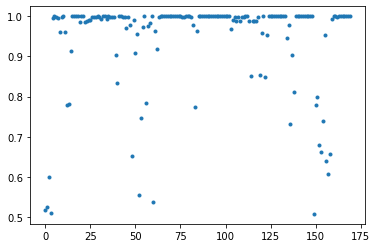

In [12]:
out_preds, out_class = F.softmax(pred_classes, dim = 2).squeeze(0).max(1)
# out_class = output_classes.squeeze(0).max(1).detach().cpu().numpy()

out_preds = out_preds.detach().cpu().numpy()
out_class = out_class.detach().cpu().numpy()
out_boxes = pred_boxes.squeeze(0).detach().cpu().numpy()

print(out_class.shape)
plt.plot(out_preds[out_class != 0],'.')
plt.show()

In [ ]:
pred_classes

In [ ]:
out_preds

In [ ]:
out_class

In [ ]:
print(torch.unique(torch.from_numpy(out_class)))

In [ ]:
n = 0
img_draw = np.clip((input_tensor[n].permute(1, 2, 0).detach().cpu().numpy() * 255),0, 255).astype(np.uint8).copy(order='C')

for box_id in range(default_boxes_xywh.shape[0]):

    if int(out_class[box_id]) != 2 or out_preds[box_id] < 0.9:
        continue
    
    Bx, By, Bw, Bh = out_boxes[box_id, :]
    Dx, Dy, Dw, Dh = default_boxes_xywh[box_id, :]    
    bx = Dx + Dw * Bx
    by = Dy + Dh * By
    bw = Dw * np.exp(Bw)
    bh = Dh * np.exp(Bh)

    x1, y1, x2, y2 = convert_xywh_to_xyxy(bx, by, bw, bh)
    x1, y1, x2, y2 = convert_normalized_to_xyxy(x1, y1, x2, y2, img_draw.shape[1], img_draw.shape[0])
    cv2.rectangle(img_draw, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 1)
    
plt.figure(figsize=(10,10))
plt.imshow(img_draw[:,:,::-1])
plt.show()

In [ ]:
final_bboxes = list()

for class_id in [1, 2]:
    mask = (out_class == class_id) * (out_preds > 0.99)
    # mask_sum = sum(mask)
    if np.sum(mask) > 0:
        sel_boxes, sel_preds, sel_default_boxes = out_boxes[mask, :][:], out_preds[mask][:], default_boxes_xywh[mask, :][:]
        sort_index = np.argsort(sel_preds)[::-1]
        sel_boxes = sel_boxes[sort_index]
        sel_preds = sel_preds[sort_index]
        sel_default_boxes = sel_default_boxes[sort_index]
        
        # convert all offsets to bbox_xyxy
        
        for box_id in range(sel_boxes.shape[0]):
            Bx, By, Bw, Bh = sel_boxes[box_id, :]
            Dx, Dy, Dw, Dh = sel_default_boxes[box_id, :]    
            bx = Dx + Dw * Bx
            by = Dy + Dh * By
            bw = Dw * np.exp(Bw)
            bh = Dh * np.exp(Bh)
            x1_min, y1_min, x1_max, y1_max = convert_xywh_to_xyxy(bx, by, bw, bh)
            sel_boxes[box_id, :] = x1_min, y1_min, x1_max, y1_max
        
        while sel_preds.shape[0] > 0:
            # print(sel_preds.shape[0])
            
            # get current bbox
            x1_min, y1_min, x1_max, y1_max = sel_boxes[0, :]
            final_bboxes.append((x1_min, y1_min, x1_max, y1_max))
            
            iou = np_calc_iou((x1_min, y1_min, x1_max, y1_max), sel_boxes)
            mask_iou_high = iou < 0.1
            
            sel_boxes = sel_boxes[mask_iou_high]
            sel_preds = sel_preds[mask_iou_high]
            

print(len(final_bboxes))
print(sel_preds)


img_draw = np.clip((input_tensor[n].squeeze(0).permute(1, 2, 0).detach().cpu().numpy() * 255),0, 255).astype(np.uint8).copy(order='C')

for x1, y1, x2, y2 in final_bboxes:

    x1, y1, x2, y2 = convert_normalized_to_xyxy(x1, y1, x2, y2, img_draw.shape[1], img_draw.shape[0])
    cv2.rectangle(img_draw, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 1)
    cv2.putText(img_draw,"car'",(int(x1), int(y1)-10),cv2.FONT_HERSHEY_COMPLEX,0.3,(0,255,0),1)
plt.figure(figsize=(10,10))
plt.imshow(img_draw[:,:,::-1])
plt.show()

In [ ]:
# cv2.rectangle(img_draw, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 1)
    
plt.figure(figsize=(10,10))
plt.imshow(img_draw[:,:,::-1])
plt.show()

# Single Image input and output code for Inferencing

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:707: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"
code/__torch__/torch/nn/functional.py:17: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


Prediction Done
(8732,)


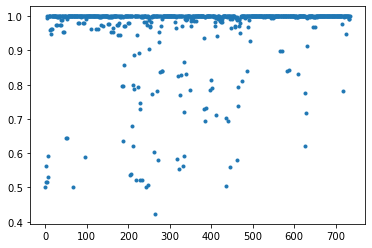

tensor([0, 1, 2])
Number of Final Boxes :  11


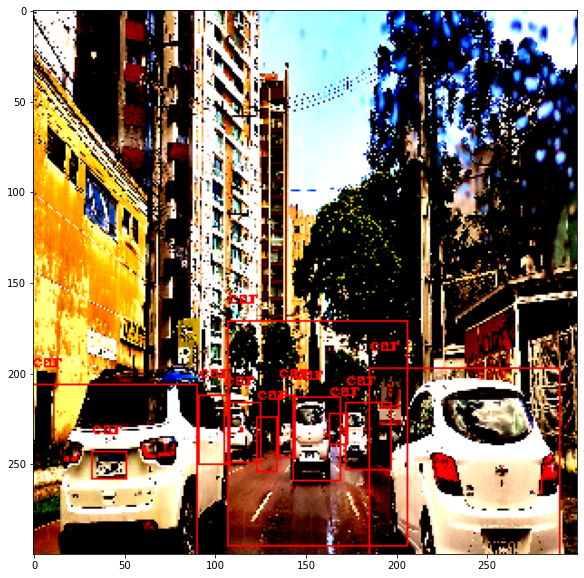

In [20]:
only_img = cv2.imread(r'S:\Lecture Notes\2nd Semester\Group Project\Edge Computing\Datacet\dataset1\4_Sunny\sunny-visible\IMG_20211226_153336.jpg')
only_img = train_transform(only_img)
only_img = only_img.unsqueeze(0)

only_img = only_img.float().to(device)

model1 = torch.load('model_scripted.pt')
with torch.no_grad():
    o_pred_boxes, o_pred_classes = model1(only_img)
    print('Prediction Done')

########################################################################################################################

o_out_preds, o_out_class = F.softmax(o_pred_classes, dim = 2).squeeze(0).max(1)
# out_class = output_classes.squeeze(0).max(1).detach().cpu().numpy()

o_out_preds = o_out_preds.detach().cpu().numpy()
o_out_class = o_out_class.detach().cpu().numpy()
o_out_boxes = o_pred_boxes.squeeze(0).detach().cpu().numpy()

print(o_out_class.shape)
plt.plot(o_out_preds[o_out_class != 0],'.')
plt.show()

print(torch.unique(torch.from_numpy(o_out_class)))
########################################################################################################################

final_bboxes = list()

for class_id in [1, 2]:
    mask = (o_out_class == class_id) * (o_out_preds > 0.99)
    # mask_sum = sum(mask)
    if np.sum(mask) > 0:
        sel_boxes, sel_preds, sel_default_boxes = o_out_boxes[mask, :][:], o_out_preds[mask][:], default_boxes_xywh[mask, :][:]
        sort_index = np.argsort(sel_preds)[::-1]
        sel_boxes = sel_boxes[sort_index]
        sel_preds = sel_preds[sort_index]
        sel_default_boxes = sel_default_boxes[sort_index]
        
        # convert all offsets to bbox_xyxy
        
        for box_id in range(sel_boxes.shape[0]):
            Bx, By, Bw, Bh = sel_boxes[box_id, :]
            Dx, Dy, Dw, Dh = sel_default_boxes[box_id, :]    
            bx = Dx + Dw * Bx
            by = Dy + Dh * By
            bw = Dw * np.exp(Bw)
            bh = Dh * np.exp(Bh)
            x1_min, y1_min, x1_max, y1_max = convert_xywh_to_xyxy(bx, by, bw, bh)
            sel_boxes[box_id, :] = x1_min, y1_min, x1_max, y1_max
        
        while sel_preds.shape[0] > 0:
            # print(sel_preds.shape[0])
            
            # get current bbox
            x1_min, y1_min, x1_max, y1_max = sel_boxes[0, :]
            final_bboxes.append((x1_min, y1_min, x1_max, y1_max))
            
            iou = np_calc_iou((x1_min, y1_min, x1_max, y1_max), sel_boxes)
            mask_iou_high = iou < 0.1
            
            sel_boxes = sel_boxes[mask_iou_high]
            sel_preds = sel_preds[mask_iou_high]
            

print('Number of Final Boxes : ', len(final_bboxes))
# print(sel_preds)


img_draw = np.clip((only_img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy() * 255),0, 255).astype(np.uint8).copy(order='C')

# print(final_bboxes)

for n in range(len(final_bboxes)):

    (x1, y1, x2, y2) = final_bboxes[n]
    x1, y1, x2, y2 = convert_normalized_to_xyxy(x1, y1, x2, y2, img_draw.shape[1], img_draw.shape[0])
    if class_id == 1:
        cv2.rectangle(img_draw, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 1)
        cv2.putText(img_draw,"plate",(int(x1), int(y1)-10),cv2.FONT_HERSHEY_COMPLEX,0.3,(0,255,0),1)
    elif class_id == 2:
        cv2.rectangle(img_draw, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 1)
        cv2.putText(img_draw,"car",(int(x1), int(y1)-10),cv2.FONT_HERSHEY_COMPLEX,0.3,(0, 0, 255),1)

plt.figure(figsize=(10,10))
plt.imshow(img_draw[:,:,::-1])
plt.show()

# PyTorch to ONNX Conversion

In [ ]:
pwd

In [ ]:
# import torch.onnx
import onnx 
import sys
sys.path.append("./onnx-tensorflow")

import onnxruntime

from onnx_tf.backend import prepare
from torch.autograd import Variable

In [ ]:
# output_boxes, output_classes = model(input_tensor)

# Export the model
torch.onnx.export(model1,               # model being run
                  only_img,                         # model input (or a tuple for multiple inputs)
                  r"C:\Users\vetsa\Desktop\EdgeComputing_Project\FinalPyTorch\ONNX\ONNX_SSD1707.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  input_names = ['input'],   # the model's input names
                  output_names = ['output']) # the model's output names
#                   opset_version=10,          # the ONNX version to export the model to
#                   do_constant_folding=True,  # whether to execute constant folding for optimization
#                   dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
#                                 'output' : {0 : 'batch_size'}})